In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cross_validation, metrics
import tensorflow as tf

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# run environment

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.4)
sess_config = tf.ConfigProto(gpu_options=gpu_options)

# label

In [3]:
labels = {'0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system', '8':'application', '9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

fault_label = {'0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system','9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

# load data

In [4]:
def one_hot(y):
    y = y.reshape(len(y))
    n_values = np.max(y) + 1
    return np.eye(n_values)[np.array(y, dtype=np.int32)]  # Returns FLOATS


def load_X(X_path):
    X_list = []
    file = open(X_path, 'r')
    # Read dataset from disk, dealing with text files' syntax
    X_signal = [np.array(item, dtype=np.float32) for item in [
               line.strip().split('\t') for line in file]]
    X_list.append(X_signal)
    file.close()
    return np.transpose(np.array(X_list), (1, 2, 0))


# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array([elem for elem in [line.strip().split('\t') for line in file]], 
                  dtype=np.int32)
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    return one_hot(y_-1)


dataset_path = "../data_msg_type/"
trainX_path = dataset_path + "semantic_train_x.txt"
trainY_path = dataset_path + "semantic_train_y.txt"
testX_path = dataset_path + "semantic_test_x.txt"
testY_path = dataset_path + "semantic_test_y.txt"


train_x = load_X(trainX_path)
train_y = load_y(trainY_path)
test_x = load_X(testX_path)
test_y = load_y(testY_path)

train_x = train_x.reshape(len(train_x), 10, 14, 1)
test_x = test_x.reshape(len(test_x), 10, 14, 1)

'''
# Separate our training data into test and training.
print("Separating data into 80% training set & 20% test set...")
train_x, test_x, train_y, test_y = cross_validation.train_test_split(
    x, y, test_size=0.2, random_state=33)#add random state here...
'''

print("Dataset separated.\n")
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

Dataset separated.

((80000, 10, 14, 1), (80000, 14), (20000, 10, 14, 1), (20000, 14))


# define parameters

In [5]:
learning_rate = 0.0001
training_iters = 16000000
batch_size = 1000
display_step = 20000

# Network Parameters
input_height = 10
input_width = 14
num_channels = 1
n_classes = 14
dropout = 0.75 # Dropout, probability to keep units

# network config

In [6]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')


# Create model
def conv_net(x, weights, biases, dropout):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 10, 14, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)
    print(conv1.shape)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)
    print(conv2.shape)
    
    # Convolution Layer
    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    conv4 = conv2d(conv3, weights['wc4'], biases['bc4'])
    conv5 = conv2d(conv4, weights['wc5'], biases['bc5'])
    # Max Pooling (down-sampling)
    conv5 = maxpool2d(conv5, k=2)
    print(conv3.shape)
    print(conv4.shape)
    print(conv5.shape)

    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv5, [-1, weights['wd1'].get_shape().as_list()[0]])
    
    # Fully connected layer
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, dropout)
    print(fc1.shape)
    fc2 = tf.add(tf.matmul(fc1, weights['wd2']), biases['bd2'])
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, dropout)
    print(fc2.shape)
    fc3 = tf.add(tf.matmul(fc2, weights['wd3']), biases['bd3'])
    fc3 = tf.nn.relu(fc3)
    fc3 = tf.nn.dropout(fc3, dropout)
    print(fc3.shape)

    # Output, class prediction
    fc4 = tf.add(tf.matmul(fc3, weights['out']), biases['out'])
    print(fc4.shape)
    return fc4

# Store layers weight & bias
weights = {
    # 3x4 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([3, 4, 1, 32])),
    # 3x4 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([3, 4, 32, 64])),
    # 3x4 conv, 64 inputs, 64 outputs
    'wc3': tf.Variable(tf.random_normal([3, 4, 64, 64])),
    # 3x4 conv, 64 inputs, 32 outputs
    'wc4': tf.Variable(tf.random_normal([3, 4, 64, 32])),
    # 3x4 conv, 32 inputs, 64 outputs
    'wc5': tf.Variable(tf.random_normal([3, 4, 32, 64])),
    # fully connected, 2*2*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([2*2*64, 1024])),
    # fully connected, 1024 inputs, 512 outputs
    'wd2': tf.Variable(tf.random_normal([1024, 512])),
    # fully connected, 512 inputs, 1024 outputs
    'wd3': tf.Variable(tf.random_normal([512, 1024])),
    # 1024 inputs, 14outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, n_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bc3': tf.Variable(tf.random_normal([64])),
    'bc4': tf.Variable(tf.random_normal([32])),
    'bc5': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'bd2': tf.Variable(tf.random_normal([512])),
    'bd3': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# build model

In [7]:
x = tf.placeholder(tf.float32, [None,input_height,input_width,num_channels])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

pred = conv_net(x, weights, biases, keep_prob)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

(?, 5, 7, 32)
(?, 3, 4, 64)
(?, 3, 4, 64)
(?, 3, 4, 32)
(?, 2, 2, 64)
(?, 1024)
(?, 512)
(?, 1024)
(?, 14)


# train and test

In [8]:
def extract_batch_size(_train, step, batch_size):   
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data.    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)
    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 
    return batch_s


test_losses = []
test_accuracies = []
test_predictions = []
train_losses = []
train_accuracies = []


init = tf.global_variables_initializer()
with tf.Session(config=sess_config) as sess:
    sess.run(init)
    
    step = 1
    # Keep training until reach max iterations
    while step * batch_size <= training_iters:
        batch_xs = extract_batch_size(train_x, step, batch_size)
        batch_ys = extract_batch_size(train_y, step, batch_size)

        # Fit training using batch data
        _, loss, acc = sess.run([optimizer, cost, accuracy],
                       feed_dict={x: batch_xs, y: batch_ys, keep_prob: dropout})

        train_losses.append(loss)
        train_accuracies.append(acc)  
        
        
        batch_xt = extract_batch_size(test_x, step, batch_size)
        batch_yt = extract_batch_size(test_y, step, batch_size)
    
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        test_predict, test_loss, test_acc = sess.run([pred, cost, accuracy], 
                                            feed_dict={x: batch_xt, y: batch_yt, keep_prob: 1.})
        
        test_predictions.append(np.argmax(test_predict, axis=1))
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        # Evaluate network only at some steps for faster training: 
        if (step*batch_size % display_step == 0) or (step == 1) \
            or (step * batch_size > training_iters):

            print("Training epochs #" + str(step*batch_size) + \
                  ": Batch Loss = " + "{:.6f}".format(loss) + \
                  ", Accuracy = {}".format(acc))
        
            print("Performance on test set: " + "Training epochs #" + str(step*batch_size) +\
                  ", Batch Loss = {}".format(test_loss) + ", Accuracy = {}".format(test_acc))
        step += 1

    print("Optimization Finished!")

Training epochs #1000: Batch Loss = 31646359552.000000, Accuracy = 0.0419999994338
Performance on test set: Training epochs #1000, Batch Loss = 16615610368.0, Accuracy = 0.00400000018999
Training epochs #20000: Batch Loss = 25207339008.000000, Accuracy = 0.00999999977648
Performance on test set: Training epochs #20000, Batch Loss = 9787928576.0, Accuracy = 0.0
Training epochs #40000: Batch Loss = 9515730944.000000, Accuracy = 0.156000003219
Performance on test set: Training epochs #40000, Batch Loss = 2162143232.0, Accuracy = 0.805000066757
Training epochs #60000: Batch Loss = 5496229888.000000, Accuracy = 0.469000011683
Performance on test set: Training epochs #60000, Batch Loss = 2904629248.0, Accuracy = 0.805000066757
Training epochs #80000: Batch Loss = 4064726528.000000, Accuracy = 0.629999935627
Performance on test set: Training epochs #80000, Batch Loss = 3015420416.0, Accuracy = 0.805000007153
Training epochs #100000: Batch Loss = 15170748416.000000, Accuracy = 0.042999997735
P

Training epochs #900000: Batch Loss = 2067684608.000000, Accuracy = 0.198999986053
Performance on test set: Training epochs #900000, Batch Loss = 57661564.0, Accuracy = 0.942999958992
Training epochs #920000: Batch Loss = 425040128.000000, Accuracy = 0.65499997139
Performance on test set: Training epochs #920000, Batch Loss = 61958840.0, Accuracy = 0.943000018597
Training epochs #940000: Batch Loss = 278666624.000000, Accuracy = 0.753000020981
Performance on test set: Training epochs #940000, Batch Loss = 94777584.0, Accuracy = 0.943000018597
Training epochs #960000: Batch Loss = 210611440.000000, Accuracy = 0.820000052452
Performance on test set: Training epochs #960000, Batch Loss = 109774552.0, Accuracy = 0.942999958992
Training epochs #980000: Batch Loss = 1837794304.000000, Accuracy = 0.198999986053
Performance on test set: Training epochs #980000, Batch Loss = 49471784.0, Accuracy = 0.943000078201
Training epochs #1000000: Batch Loss = 369334880.000000, Accuracy = 0.682000041008


Training epochs #1800000: Batch Loss = 115157656.000000, Accuracy = 0.810000002384
Performance on test set: Training epochs #1800000, Batch Loss = 16638806.0, Accuracy = 0.963999986649
Training epochs #1820000: Batch Loss = 93860904.000000, Accuracy = 0.844999969006
Performance on test set: Training epochs #1820000, Batch Loss = 26415678.0, Accuracy = 0.958000004292
Training epochs #1840000: Batch Loss = 60494032.000000, Accuracy = 0.893999934196
Performance on test set: Training epochs #1840000, Batch Loss = 30344434.0, Accuracy = 0.958000004292
Training epochs #1860000: Batch Loss = 723958144.000000, Accuracy = 0.293000012636
Performance on test set: Training epochs #1860000, Batch Loss = 11887846.0, Accuracy = 0.963999986649
Training epochs #1880000: Batch Loss = 120964552.000000, Accuracy = 0.788999974728
Performance on test set: Training epochs #1880000, Batch Loss = 15025359.0, Accuracy = 0.963999986649
Training epochs #1900000: Batch Loss = 86994352.000000, Accuracy = 0.85299998

Training epochs #2700000: Batch Loss = 47614420.000000, Accuracy = 0.888999998569
Performance on test set: Training epochs #2700000, Batch Loss = 9324148.0, Accuracy = 0.964000046253
Training epochs #2720000: Batch Loss = 28852802.000000, Accuracy = 0.915999948978
Performance on test set: Training epochs #2720000, Batch Loss = 10206633.0, Accuracy = 0.964000046253
Training epochs #2740000: Batch Loss = 370982944.000000, Accuracy = 0.403999984264
Performance on test set: Training epochs #2740000, Batch Loss = 4014680.5, Accuracy = 0.978000044823
Training epochs #2760000: Batch Loss = 55622304.000000, Accuracy = 0.851000070572
Performance on test set: Training epochs #2760000, Batch Loss = 4481758.0, Accuracy = 0.963999986649
Training epochs #2780000: Batch Loss = 43644480.000000, Accuracy = 0.896000087261
Performance on test set: Training epochs #2780000, Batch Loss = 8483930.0, Accuracy = 0.964000046253
Training epochs #2800000: Batch Loss = 33218080.000000, Accuracy = 0.915000081062
P

Training epochs #3600000: Batch Loss = 15416206.000000, Accuracy = 0.933000028133
Performance on test set: Training epochs #3600000, Batch Loss = 2328587.0, Accuracy = 0.978000044823
Training epochs #3620000: Batch Loss = 200870288.000000, Accuracy = 0.471999973059
Performance on test set: Training epochs #3620000, Batch Loss = 1166243.0, Accuracy = 0.994000077248
Training epochs #3640000: Batch Loss = 23082338.000000, Accuracy = 0.905999958515
Performance on test set: Training epochs #3640000, Batch Loss = 1398797.25, Accuracy = 0.993000030518
Training epochs #3660000: Batch Loss = 22453476.000000, Accuracy = 0.912000060081
Performance on test set: Training epochs #3660000, Batch Loss = 1926198.5, Accuracy = 0.98500007391
Training epochs #3680000: Batch Loss = 13270126.000000, Accuracy = 0.93599998951
Performance on test set: Training epochs #3680000, Batch Loss = 2162927.0, Accuracy = 0.978000044823
Training epochs #3700000: Batch Loss = 180134368.000000, Accuracy = 0.513000011444
Pe

Training epochs #4500000: Batch Loss = 111390856.000000, Accuracy = 0.568000018597
Performance on test set: Training epochs #4500000, Batch Loss = 681142.1875, Accuracy = 0.991000056267
Training epochs #4520000: Batch Loss = 13377589.000000, Accuracy = 0.925000011921
Performance on test set: Training epochs #4520000, Batch Loss = 1097485.25, Accuracy = 0.991000056267
Training epochs #4540000: Batch Loss = 8667732.000000, Accuracy = 0.950000107288
Performance on test set: Training epochs #4540000, Batch Loss = 546829.375, Accuracy = 0.993000030518
Training epochs #4560000: Batch Loss = 6392902.500000, Accuracy = 0.955000042915
Performance on test set: Training epochs #4560000, Batch Loss = 452247.75, Accuracy = 0.993000030518
Training epochs #4580000: Batch Loss = 109411440.000000, Accuracy = 0.584999978542
Performance on test set: Training epochs #4580000, Batch Loss = 658757.3125, Accuracy = 0.990999996662
Training epochs #4600000: Batch Loss = 10824746.000000, Accuracy = 0.9309999942

Training epochs #5400000: Batch Loss = 5652772.000000, Accuracy = 0.953999996185
Performance on test set: Training epochs #5400000, Batch Loss = 608273.9375, Accuracy = 0.991000056267
Training epochs #5420000: Batch Loss = 5969331.000000, Accuracy = 0.959000051022
Performance on test set: Training epochs #5420000, Batch Loss = 122083.828125, Accuracy = 0.990000009537
Training epochs #5440000: Batch Loss = 2701289.250000, Accuracy = 0.975000083447
Performance on test set: Training epochs #5440000, Batch Loss = 9175.34472656, Accuracy = 0.996999979019
Training epochs #5460000: Batch Loss = 64470972.000000, Accuracy = 0.667999982834
Performance on test set: Training epochs #5460000, Batch Loss = 339041.75, Accuracy = 0.994000077248
Training epochs #5480000: Batch Loss = 4585530.000000, Accuracy = 0.960000038147
Performance on test set: Training epochs #5480000, Batch Loss = 421122.09375, Accuracy = 0.990999996662
Training epochs #5500000: Batch Loss = 6391624.000000, Accuracy = 0.95400005

Training epochs #6300000: Batch Loss = 3469412.750000, Accuracy = 0.965000033379
Performance on test set: Training epochs #6300000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #6320000: Batch Loss = 1474413.000000, Accuracy = 0.980000019073
Performance on test set: Training epochs #6320000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #6340000: Batch Loss = 29100222.000000, Accuracy = 0.763000011444
Performance on test set: Training epochs #6340000, Batch Loss = 85941.3125, Accuracy = 0.994000077248
Training epochs #6360000: Batch Loss = 2748546.000000, Accuracy = 0.97000002861
Performance on test set: Training epochs #6360000, Batch Loss = 14858.1367188, Accuracy = 0.997000098228
Training epochs #6380000: Batch Loss = 3554083.250000, Accuracy = 0.961000025272
Performance on test set: Training epochs #6380000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #6400000: Batch Loss = 1644863.375000, Accuracy = 0.979999959469
Performance on test set: Training e

Training epochs #7220000: Batch Loss = 17222936.000000, Accuracy = 0.799999952316
Performance on test set: Training epochs #7220000, Batch Loss = 6518.40039062, Accuracy = 0.994000077248
Training epochs #7240000: Batch Loss = 2003627.000000, Accuracy = 0.969000041485
Performance on test set: Training epochs #7240000, Batch Loss = 99891.859375, Accuracy = 0.996999979019
Training epochs #7260000: Batch Loss = 2551719.500000, Accuracy = 0.97100007534
Performance on test set: Training epochs #7260000, Batch Loss = 24918.5664062, Accuracy = 0.997000098228
Training epochs #7280000: Batch Loss = 720334.000000, Accuracy = 0.986000001431
Performance on test set: Training epochs #7280000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #7300000: Batch Loss = 23488306.000000, Accuracy = 0.78100001812
Performance on test set: Training epochs #7300000, Batch Loss = 20035.1523438, Accuracy = 0.994000077248
Training epochs #7320000: Batch Loss = 2023049.375000, Accuracy = 0.97200012207
Per

Training epochs #8140000: Batch Loss = 1857846.125000, Accuracy = 0.975000023842
Performance on test set: Training epochs #8140000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #8160000: Batch Loss = 628498.562500, Accuracy = 0.989000022411
Performance on test set: Training epochs #8160000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #8180000: Batch Loss = 10654292.000000, Accuracy = 0.827999949455
Performance on test set: Training epochs #8180000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #8200000: Batch Loss = 1336172.500000, Accuracy = 0.975999951363
Performance on test set: Training epochs #8200000, Batch Loss = 34688.2148438, Accuracy = 0.996999979019
Training epochs #8220000: Batch Loss = 1116407.375000, Accuracy = 0.98299998045
Performance on test set: Training epochs #8220000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #8240000: Batch Loss = 447039.125000, Accuracy = 0.985000014305
Performance on test set: Training epochs #824

Training epochs #9080000: Batch Loss = 596149.437500, Accuracy = 0.980000019073
Performance on test set: Training epochs #9080000, Batch Loss = 32204.0917969, Accuracy = 0.996999979019
Training epochs #9100000: Batch Loss = 1649313.500000, Accuracy = 0.975000023842
Performance on test set: Training epochs #9100000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #9120000: Batch Loss = 213189.593750, Accuracy = 0.986000061035
Performance on test set: Training epochs #9120000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #9140000: Batch Loss = 6914056.000000, Accuracy = 0.856999993324
Performance on test set: Training epochs #9140000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #9160000: Batch Loss = 845457.625000, Accuracy = 0.978999972343
Performance on test set: Training epochs #9160000, Batch Loss = 5808.81054688, Accuracy = 0.996999979019
Training epochs #9180000: Batch Loss = 690302.500000, Accuracy = 0.986000001431
Performance on test set: T

Training epochs #10020000: Batch Loss = 5000392.000000, Accuracy = 0.879000008106
Performance on test set: Training epochs #10020000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #10040000: Batch Loss = 373207.781250, Accuracy = 0.986000061035
Performance on test set: Training epochs #10040000, Batch Loss = 32200.546875, Accuracy = 0.996999979019
Training epochs #10060000: Batch Loss = 455581.875000, Accuracy = 0.988000035286
Performance on test set: Training epochs #10060000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #10080000: Batch Loss = 191134.031250, Accuracy = 0.995000123978
Performance on test set: Training epochs #10080000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #10100000: Batch Loss = 5015760.000000, Accuracy = 0.858000040054
Performance on test set: Training epochs #10100000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #10120000: Batch Loss = 571950.062500, Accuracy = 0.981999993324
Performance on test set: Tr

Training epochs #10960000: Batch Loss = 40641.593750, Accuracy = 0.998000085354
Performance on test set: Training epochs #10960000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #10980000: Batch Loss = 3065711.000000, Accuracy = 0.880999982357
Performance on test set: Training epochs #10980000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11000000: Batch Loss = 339764.625000, Accuracy = 0.986999988556
Performance on test set: Training epochs #11000000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11020000: Batch Loss = 203971.703125, Accuracy = 0.991999983788
Performance on test set: Training epochs #11020000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11040000: Batch Loss = 54621.363281, Accuracy = 0.996000051498
Performance on test set: Training epochs #11040000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11060000: Batch Loss = 3983123.000000, Accuracy = 0.865000009537
Performance on test set: Training epoch

Training epochs #11900000: Batch Loss = 131081.468750, Accuracy = 0.993000030518
Performance on test set: Training epochs #11900000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11920000: Batch Loss = 82996.203125, Accuracy = 0.996999979019
Performance on test set: Training epochs #11920000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11940000: Batch Loss = 2545947.500000, Accuracy = 0.885000050068
Performance on test set: Training epochs #11940000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11960000: Batch Loss = 201110.718750, Accuracy = 0.991000056267
Performance on test set: Training epochs #11960000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11980000: Batch Loss = 128401.750000, Accuracy = 0.992000102997
Performance on test set: Training epochs #11980000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12000000: Batch Loss = 56606.812500, Accuracy = 0.997000098228
Performance on test set: Training epochs

Training epochs #12840000: Batch Loss = 161263.906250, Accuracy = 0.989000022411
Performance on test set: Training epochs #12840000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12860000: Batch Loss = 90191.156250, Accuracy = 0.992000043392
Performance on test set: Training epochs #12860000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12880000: Batch Loss = 41437.554688, Accuracy = 0.995000004768
Performance on test set: Training epochs #12880000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12900000: Batch Loss = 1329277.500000, Accuracy = 0.904000043869
Performance on test set: Training epochs #12900000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12920000: Batch Loss = 31178.089844, Accuracy = 0.995999991894
Performance on test set: Training epochs #12920000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12940000: Batch Loss = 143608.609375, Accuracy = 0.990999996662
Performance on test set: Training epochs 

Training epochs #13780000: Batch Loss = 957423.312500, Accuracy = 0.92300003767
Performance on test set: Training epochs #13780000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13800000: Batch Loss = 65052.890625, Accuracy = 0.993000030518
Performance on test set: Training epochs #13800000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13820000: Batch Loss = 107167.890625, Accuracy = 0.995000123978
Performance on test set: Training epochs #13820000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13840000: Batch Loss = 13527.652344, Accuracy = 0.999000072479
Performance on test set: Training epochs #13840000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13860000: Batch Loss = 736122.750000, Accuracy = 0.93700003624
Performance on test set: Training epochs #13860000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13880000: Batch Loss = 42216.699219, Accuracy = 0.991999924183
Performance on test set: Training epochs #13

Training epochs #14720000: Batch Loss = 5658.882324, Accuracy = 0.998000025749
Performance on test set: Training epochs #14720000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14740000: Batch Loss = 591887.687500, Accuracy = 0.949000000954
Performance on test set: Training epochs #14740000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14760000: Batch Loss = 172528.015625, Accuracy = 0.983000040054
Performance on test set: Training epochs #14760000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14780000: Batch Loss = 9468.073242, Accuracy = 0.998000025749
Performance on test set: Training epochs #14780000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14800000: Batch Loss = 48741.433594, Accuracy = 0.996999979019
Performance on test set: Training epochs #14800000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14820000: Batch Loss = 664381.875000, Accuracy = 0.945000112057
Performance on test set: Training epochs #14

Training epochs #15680000: Batch Loss = 0.000000, Accuracy = 1.00000011921
Performance on test set: Training epochs #15680000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15700000: Batch Loss = 436332.718750, Accuracy = 0.956000030041
Performance on test set: Training epochs #15700000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15720000: Batch Loss = 95107.804688, Accuracy = 0.993000030518
Performance on test set: Training epochs #15720000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15740000: Batch Loss = 48103.332031, Accuracy = 0.994000077248
Performance on test set: Training epochs #15740000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15760000: Batch Loss = 14438.468750, Accuracy = 0.998000144958
Performance on test set: Training epochs #15760000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15780000: Batch Loss = 856669.000000, Accuracy = 0.953000068665
Performance on test set: Training epochs #157800

# performance visualization

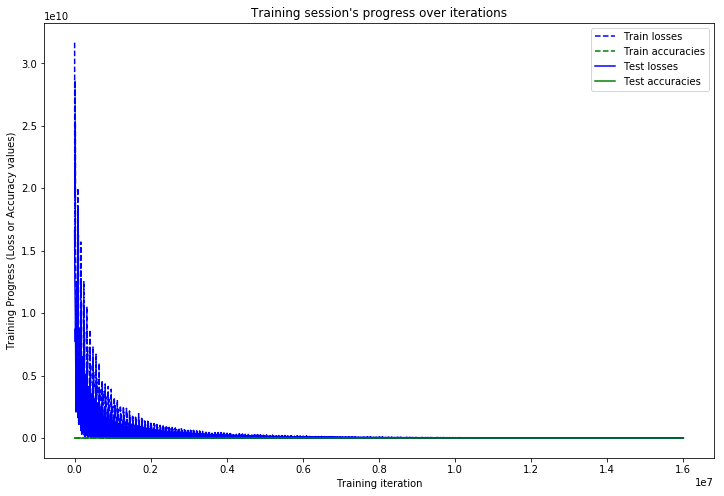

In [9]:
#font = {'family': 'Bitstream Vera Sans', 'weight': 'bold', 'size': 12}
#matplotlib.rc('font', **font)
width = 12
height = 8
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, 
                   (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses), "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(np.array(range(batch_size, 
                  len(test_losses)*batch_size, batch_size)), training_iters)
plt.plot(indep_test_axis, np.array(test_losses), "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=False)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')
plt.savefig('result/lstm_loss_accuracy.png')
plt.figure()
plt.show()

Best Testing Accuracy: 100.000011921%

Precision: 97.3640123525%
Recall: 97.38%
f1_score: 97.3100282041%

Confusion Matrix:
[[    5    12     0     0     0     1     0     0     0     0     0     0
      0]
 [   15   785     0     0    28    11    30    12    11     0     0    19
      0]
 [    0     0   213     0     0     0     0     0     0     0     0     0
      0]
 [    0     2     0     0     0     0     0     0     0     0     0     0
      0]
 [    0    14     0     0  2830     0     0    44     0     0     0     3
      0]
 [    7    36     0     0     0   286     9     1     4     3     0     2
      0]
 [    0     7     0     0     0     0 14486     0     2     0     0     0
      0]
 [    0    68     0     0    34    21    28   356    16     0     0    12
      0]
 [    0     0     0     0     0     0     0     0   132     0     0     0
      0]
 [    0     0     0     0     0     0     0     0     2     2     0     0
      0]
 [    0     0     0     0     0     0     0   

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


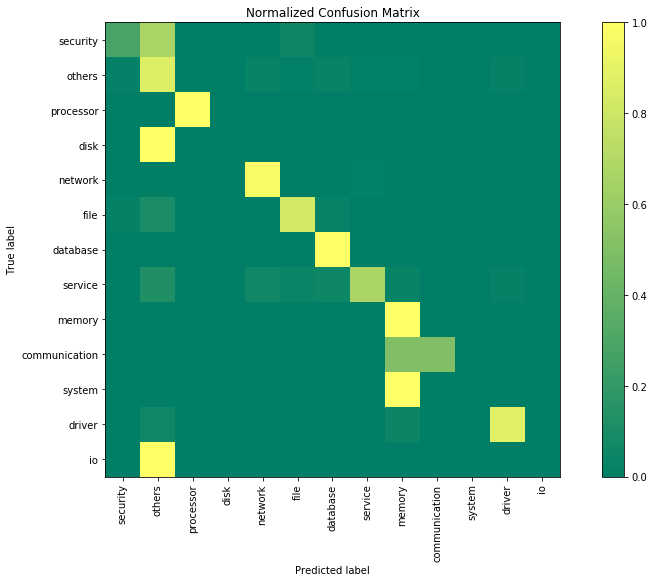

In [10]:
# Results
predictions = []
length = len(test_predictions)-20
for i in range(20):
    predictions.extend(test_predictions[length+i])

true_y = np.argmax(test_y, axis=1)

print("Best Testing Accuracy: {}%".format(100*max(test_accuracies)))

print("")
print("Precision: {}%".format(100*metrics.precision_score(
    true_y, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(true_y, 
    predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(true_y, 
    predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(true_y, predictions)
print(confusion_matrix)

# Plot: 
## cmap can be changed to many colors, (colormaps.Oranges,OrRd, etc)
def plot_CM(cm, title="Normalized Confusion Matrix", cmap=plt.cm.summer):
    width = 12
    height = 8
    plt.figure(figsize=(width, height))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(fault_label))
    plt.xticks(tick_marks, fault_label.values(), rotation=90)
    plt.yticks(tick_marks, fault_label.values())
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()
    
print(metrics.classification_report(
    true_y, predictions, target_names = list(labels.values())))

cm = confusion_matrix

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
plt.figure()
plot_CM(cm_normalized)